#**<center>Natural Language Text to SQL Query Conversion**
##**<center>GRU based Encoder-Decoder model**

###**Importing necessary libraries**

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pip install records

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import records
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import time
import unicodedata

from __future__ import unicode_literals, print_function, division

from collections import defaultdict
from io import open
from __future__ import unicode_literals, print_function, division


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from torch.autograd import Variable
from torch import optim

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/lib/')

In [ ]:
from lib_db import *

In [ ]:
"""
Device
"""
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

###**Preparing training data**

In [ ]:
SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = defaultdict(int)
        self.word2count = defaultdict(int)
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1




In [ ]:
"""
To Load the train data from file into the memory  
"""
def readLangs(lang1, lang2):
    print("Reading lines...")

    lines = pd.read_json("/content/drive/MyDrive/Data606_finalproject/output/tokenized_train.jsonl", lines=True)

    # Split every line into pairs
    pairs= []
    for idx, row in lines.iterrows():
        tokens_en = row["tokenized_question"]
        tokens_sql = row["tokenized_query"]
        pairs.append([tokens_en, tokens_sql])

    input_lang = Language(lang1)
    output_lang = Language(lang2)

    return input_lang, output_lang, pairs

"""To complete the mapping of all string data to numeric data and filter language pairs
               The parameters lang1, lang2 represent the name of the source language and target language """

def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    print("\nCounting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Number of words in", input_lang.name, input_lang.n_words)
    print("Number of words in", output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
global input_lang
global output_lang
global pairs


input_lang, output_lang, pairs= prepareData("en", "sql")
print("\nRandom Question and query pair looks like:\n")
print(random.choice(pairs))
#output_lang.word2index

Reading lines...
Read 56355 sentence pairs

Counting words...
Number of words in en 39685
Number of words in sql 38066

Random Question and query pair looks like:

[['what', 'is', 'win-loss', ',', 'when', 'win', '%', 'is', '.456', '?'], ['SELECT', 'win-loss', 'FROM', 'table_', 'WHERE', 'win', '%', 'EQL', '.456']]


In [ ]:
"""
To convert language pairs into tensors to input the model
"""
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)



In [ ]:
pair = pairs[0]
print(pair)
training_pairs = tensorsFromPair(pair)
print("\nTensor for Question and query pair looks like:\n")
training_pairs

[['tell', 'me', 'what', 'the', 'notes', 'are', 'for', 'south', 'australia'], ['SELECT', 'notes', 'FROM', 'table_', 'WHERE', 'current', 'slogan', 'EQL', 'south', 'australia']]

Tensor for Question and query pair looks like:



(tensor([[ 2],
         [ 3],
         [ 4],
         [ 5],
         [ 6],
         [ 7],
         [ 8],
         [ 9],
         [10],
         [ 1]], device='cuda:0'), tensor([[ 2],
         [ 3],
         [ 4],
         [ 5],
         [ 6],
         [ 7],
         [ 8],
         [ 9],
         [10],
         [11],
         [ 1]], device='cuda:0'))

In [ ]:
"""
To prepare validation data
"""
def readLangs_val(lang1, lang2):
    print("Reading lines...")

    lines = pd.read_json("/content/drive/MyDrive/Data606_finalproject/output/tokenized_test.jsonl", lines=True)

    # Split every line into pairs and normalize
    pairs = []
    for idx, row in lines.iterrows():
        tokens_en = row["tokenized_question"]
        tokens_sql = row["tokenized_query"]
        pairs.append([tokens_en, tokens_sql])

    input_lang = Language(lang1)
    output_lang = Language(lang2)

    return input_lang, output_lang, pairs


def prepareValData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs_val(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [ ]:
global pairs_test

input_lang, output_lang, pairs_test= prepareValData("en", "sql")
print("\nRandom Question and query pair looks like:\n")
print(random.choice(pairs_test))

Reading lines...
Read 15878 sentence pairs
Trimmed to 15878 sentence pairs
Counting words...
Counted words:
en 16358
sql 15618

Random Question and query pair looks like:

[['who', 'directed', 'the', 'episode', 'that', 'aired', 'on', 'july15,2012', '?'], ['SELECT', 'directed', 'by', 'FROM', 'table_', 'WHERE', 'original', 'air', 'date', 'EQL', 'july15,2012']]


###**Building GRU-based encoder and decoder model**

###**Encoder**

In [ ]:
"""
RNN Encoder
"""
class RNN_Encoder(nn.Module):
    def __init__(self, input_size, hidden_size,dropout):
        super(RNN_Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

###**Decoder**

In [ ]:
"""
Decoder
"""
class RNN_Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RNN_Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

###**Attention Decoder**

In [ ]:
MAX_LENGTH = 50
"""
Attention Decoder
"""

class RNN_AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p, max_length=MAX_LENGTH):
        super(RNN_AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

###**Training function**

In [ ]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length): 
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

###**Time Calculation**

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

###**Function to plot graphs**

In [ ]:
def showPlot(points, plot_name):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig(plot_name + ".png")


def plot_data(x, y, xlabel = "x", ylabel = "y", label = 'plot'):
	plt.figure()
	plt.plot(x, y)
	plt.xlabel("Epochs")
	plt.ylabel("Loss")
	print("Generating plot for ", label)
	plt.savefig("./" + label + ".png")

###**To call training function and print graphs and logs**

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        # training_pair = tensorsFromPair(random.choice(pairs))
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                      iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses, "Baseline loss")

###**Training the model**

0m 31s (- 7m 15s) (1000 6%) 3.6885
1m 1s (- 6m 39s) (2000 13%) 3.1792
1m 32s (- 6m 8s) (3000 20%) 3.0379
2m 2s (- 5m 36s) (4000 26%) 2.9508
2m 33s (- 5m 7s) (5000 33%) 2.7966
3m 4s (- 4m 36s) (6000 40%) 2.7779
3m 35s (- 4m 6s) (7000 46%) 2.6418
4m 6s (- 3m 35s) (8000 53%) 2.5140
4m 36s (- 3m 4s) (9000 60%) 2.5354
5m 7s (- 2m 33s) (10000 66%) 2.4404
5m 37s (- 2m 2s) (11000 73%) 2.4100
6m 8s (- 1m 32s) (12000 80%) 2.3467
6m 39s (- 1m 1s) (13000 86%) 2.3515
7m 10s (- 0m 30s) (14000 93%) 2.2535
7m 41s (- 0m 0s) (15000 100%) 2.2615


<Figure size 432x288 with 0 Axes>

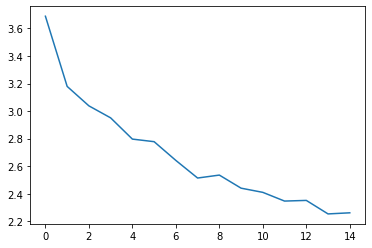

In [ ]:
dropout = 0.5
dropout_p = 0.5
hidden_size = 256


encoder1 = RNN_Encoder(input_lang.n_words, hidden_size,dropout).to(device)

attn_decoder1 = RNN_AttnDecoder(hidden_size, output_lang.n_words, dropout_p).to(device)

trainIters(encoder1, attn_decoder1, n_iters = 15000, print_every=1000, plot_every=1000,learning_rate= 0.001)


###**Model evaluation function**

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=50):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=20):
    correct = 0
    for i in range(n):
        pair = random.choice(pairs)
        print('\nEnglish Question-', pair[0])
        print('Ground truth Query-', pair[1])
        generated_tokens, attentions = evaluate(encoder, decoder, pair[0])
        generated_query = ' '.join(generated_tokens)
        if generated_query[:-6] == pair[1]:
            correct += 1
        print('Generated Query-', generated_query)
    

In [ ]:

evaluateRandomly(encoder1, attn_decoder1)



English Question- ['what', 'were', 'the', 'high', 'assist', 'on', 'january', '2', '?']
Ground truth Query- ['SELECT', 'high', 'assists', 'FROM', 'table_', 'WHERE', 'date', 'EQL', 'january', '2']
Generated Query- SELECT high 2 FROM table_ WHERE date EQL january 2 <EOS>

English Question- ['who', 'is', 'the', 'republican', 'incumbent', 'for', 'pennsylvania', '9', '?']
Ground truth Query- ['SELECT', 'incumbent', 'FROM', 'table_', 'WHERE', 'party', 'EQL', 'republican', 'AND', 'district', 'EQL', 'pennsylvania', '9']
Generated Query- SELECT incumbent FROM table_ WHERE year EQL 9 <EOS>

English Question- ['what', 'is', 'the', 'average', '2006', 'value', 'with', 'a', '2010', 'value', 'of', '417.9', 'and', 'a', '2011', 'value', 'greater', 'than', '426.7', '?']
Ground truth Query- ['SELECT', 'avg', '(', '2006', ')', 'FROM', 'table_', 'WHERE', '2010', 'EQL', '417.9', 'AND', '2011', 'GT', '426.7']
Generated Query- SELECT avg ( table_ WHERE WHERE table_ WHERE SOS SOS SOS 2011 EQL SOS <EOS>

Englis

References:
1. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html